In [7]:
!pip install ultralytics ipywidgets opencv-python matplotlib --quiet

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics.data.augment import LetterBox, RandomPerspective

import ipywidgets as widgets
from ipywidgets import interact

In [6]:
import cv2
import numpy as np

def augment_hsv(img, hgain=0.015, sgain=0.7, vgain=0.4):
    """Applique une variation HSV à l'image (comme YOLO)."""
    if hgain or sgain or vgain:
        r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
        hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))

        dtype = img.dtype
        x = np.arange(0, 256, dtype=np.int16)

        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        img_hsv = cv2.merge((cv2.LUT(hue, lut_hue),
                             cv2.LUT(sat, lut_sat),
                             cv2.LUT(val, lut_val)))
        img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return img


In [11]:
# 📌 Notebook interactif : Visualisation des augmentations YOLO
# Compatible Jupyter et Google Colab


# ======= Charger une image =======
# Remplace par ton image médicale d'exemple
IMG_PATH = "/content/drive/MyDrive/projet_yolo_medical/data/images/train/01.jpg"
img_original = cv2.imread(IMG_PATH)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

# ======= Fonction d'augmentation =======
def random_perspective_img(img, degrees=0, translate=0, scale=0, shear=0):
    """Version simplifiée de RandomPerspective pour une seule image."""
    height, width = img.shape[:2]

    # Rotation + scale
    R = cv2.getRotationMatrix2D((width / 2, height / 2),
                                angle=np.random.uniform(-degrees, degrees),
                                scale=np.random.uniform(1 - scale, 1 + scale))

    # Translation
    tx = np.random.uniform(-translate, translate) * width
    ty = np.random.uniform(-translate, translate) * height
    R[:, 2] += (tx, ty)

    # Shear
    shear_x = np.random.uniform(-shear, shear)
    shear_y = np.random.uniform(-shear, shear)
    M_shear = np.array([[1, shear_x, 0],
                        [shear_y, 1, 0]], dtype=np.float32)

    # Appliquer rotation/scale
    img = cv2.warpAffine(img, R, (width, height), borderValue=(114, 114, 114))

    # Appliquer shear
    img = cv2.warpAffine(img, M_shear, (width, height), borderValue=(114, 114, 114))

    return img

def apply_augmentation(
    mosaic=1.0,
    mixup=0.0,
    hsv_h=0.015,
    hsv_s=0.5,
    hsv_v=0.4,
    degrees=5.0,
    translate=0.1,
    scale=0.5,
    shear=2.0
):
    img = img_original.copy()

    # Letterbox
    lb = LetterBox(new_shape=640)
    img = lb(image=img)

    # HSV
    img = augment_hsv(img, hgain=hsv_h, sgain=hsv_s, vgain=hsv_v)

    # Random Perspective simplifié
    img = random_perspective_img(img, degrees=degrees, translate=translate, scale=scale, shear=shear)

    # Affichage
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


# ======= Interface interactive =======
interact(
    apply_augmentation,
    mosaic=widgets.FloatSlider(value=1.0, min=0, max=1, step=0.1),
    mixup=widgets.FloatSlider(value=0.0, min=0, max=1, step=0.1),
    hsv_h=widgets.FloatSlider(value=0.015, min=0, max=0.1, step=0.005),
    hsv_s=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05),
    hsv_v=widgets.FloatSlider(value=0.4, min=0, max=1, step=0.05),
    degrees=widgets.FloatSlider(value=5.0, min=-15, max=15, step=1),
    translate=widgets.FloatSlider(value=0.1, min=0, max=0.5, step=0.05),
    scale=widgets.FloatSlider(value=0.5, min=0, max=1.5, step=0.05),
    shear=widgets.FloatSlider(value=2.0, min=-10, max=10, step=0.5)
)


interactive(children=(FloatSlider(value=1.0, description='mosaic', max=1.0), FloatSlider(value=0.0, descriptio…

<function __main__.apply_augmentation(mosaic=1.0, mixup=0.0, hsv_h=0.015, hsv_s=0.5, hsv_v=0.4, degrees=5.0, translate=0.1, scale=0.5, shear=2.0)>

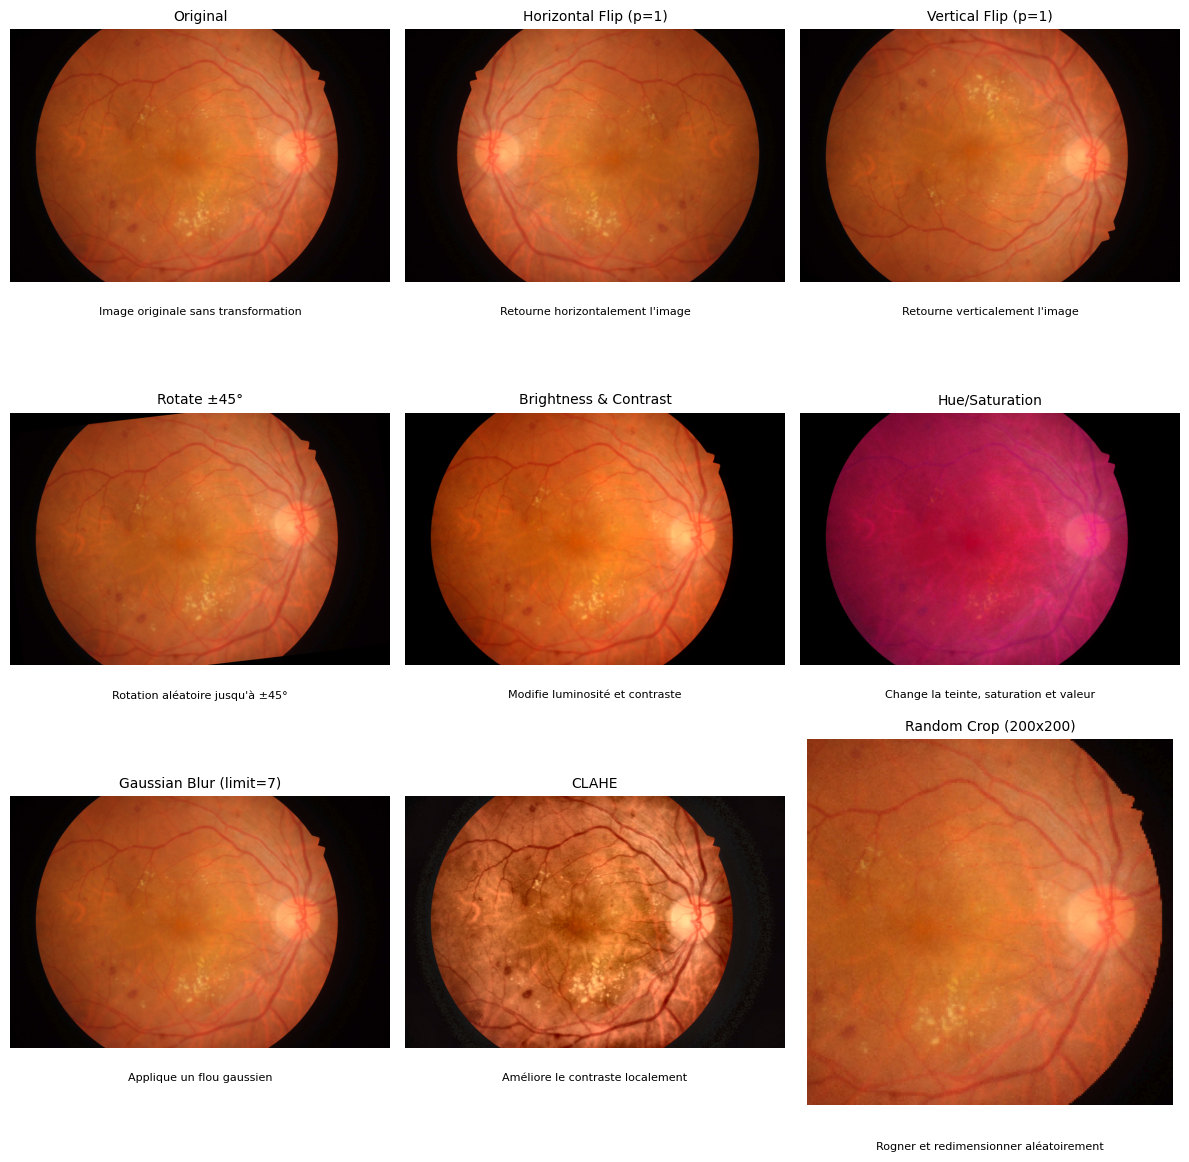

In [23]:
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import numpy as np

# Charger une image (BGR -> RGB)
img = cv2.imread("/content/drive/MyDrive/projet_yolo_medical/data/images/train/01.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Liste des transformations
transformations = [
    # (Nom affiché, Transformation, Description)
    ("Original", None, "Image originale sans transformation"),
    ("Horizontal Flip (p=1)", A.HorizontalFlip(p=1), "Retourne horizontalement l'image"),
    ("Vertical Flip (p=1)", A.VerticalFlip(p=1), "Retourne verticalement l'image"),
    ("Rotate ±45°", A.Rotate(limit=45, p=1), "Rotation aléatoire jusqu'à ±45°"),
    ("Brightness & Contrast", A.RandomBrightnessContrast(p=1), "Modifie luminosité et contraste"),
    ("Hue/Saturation", A.HueSaturationValue(p=1), "Change la teinte, saturation et valeur"),
    ("Gaussian Blur (limit=7)", A.GaussianBlur(p=1, blur_limit=7), "Applique un flou gaussien"),
    ("CLAHE", A.CLAHE(p=1), "Améliore le contraste localement"),
    ("Random Crop (200x200)", A.RandomResizedCrop(size=(200, 200), p=1), "Rogner et redimensionner aléatoirement")
]


# Création du plot
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i, (name, transform,desc) in enumerate(transformations):
    if transform is None:
        aug_img = img
    else:
        # Albumentations works with dictionaries
        augmented = transform(image=img)
        aug_img = augmented["image"]

    axes[i].imshow(aug_img)
    axes[i].set_title(name, fontsize=10)
    axes[i].axis("off")
    axes[i].text(0.5, -0.1, desc, fontsize=8, ha='center', va='top', transform=axes[i].transAxes, wrap=True)


plt.tight_layout()
plt.show()